# ===   EDA. Predict rating hotels  ===

## Import Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.feature_selection import chi2, f_classif
import category_encoders as ce
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download necessary resources for sentiment analysis
nltk.download('vader_lexicon')

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Load and Combine Train and Test Data

In [2]:
DATA_DIR = '/kaggle/input/sf-booking/'

df_train = pd.read_csv(DATA_DIR + '/hotels_train.csv')
df_test = pd.read_csv(DATA_DIR + '/hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR + '/submission.csv')

# Add sample flags
df_train['sample'] = 1  # training data
df_test['sample'] = 0   # test data
df_test['reviewer_score'] = 0  # placeholder for target

# Combine train and test for consistent preprocessing
data = pd.concat([df_test, df_train], axis=0).reset_index(drop=True)
print(f"Combined dataset shape: {data.shape}")

Combined dataset shape: (515738, 18)


In [3]:
data

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050,1,8.8
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451,1,9.2
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084,1,8.3
515736,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066,1,9.2


# Initial Exploration & Cleaning

In [4]:
# Create a copy for feature engineering
n_hotels = data.copy()

In [5]:
#data['hotel_name'].nunique()
# Проверим на наличие дубликатов и отфильтруем их 

L0=len(n_hotels)
n_hotels.drop_duplicates(inplace=True)
L1=len(n_hotels)

print('Обнаружено {} дубликатов'.format(L0-L1))


Обнаружено 336 дубликатов


In [6]:
print("Number of unique hotels:", n_hotels['hotel_name'].nunique())

# Convert review date to datetime format
n_hotels['review_date'] = pd.to_datetime(n_hotels['review_date'])



Number of unique hotels: 1492


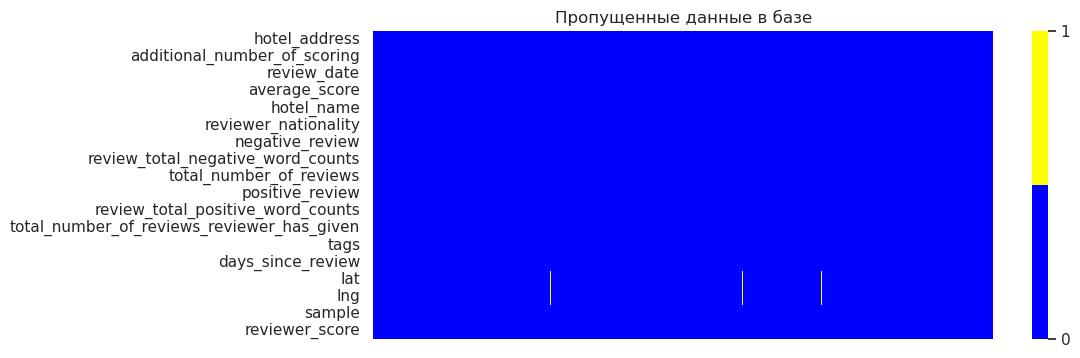

In [7]:
# Строим тепловую карту, где желтым отмечены пропущеные значения
cbar_kws = { 'ticks' : [0,1] }
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    n_hotels.T.isnull(), # Создаем карту пропущенных значений в базе данных
    cmap=sns.color_palette(colors),
    xticklabels=False,
    cbar_kws = cbar_kws
)
ax.set_title('Пропущенные данные в базе');

**Observation:** There missing lat lng for some positions in our data set

## Filling in the gaps in geographic coordinates. (Feature generation)

In [8]:
n_hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score'],
      dtype='object')

In [9]:
n_hotels[n_hotels['lat'].isnull()][['hotel_name', 'hotel_address']]


,hotel_name,hotel_address
35,Hotel Atlanta,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...
293,Hotel Atlanta,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...
476,City Hotel Deutschmeister,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...
526,Holiday Inn Paris Montmartre,23 Rue Damr mont 18th arr 75018 Paris France
569,Fleming s Selection Hotel Wien City,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...
...,...,...
515027,Hotel City Central,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...
515400,Hotel City Central,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...
515439,Maison Albar Hotel Paris Op ra Diamond,4 rue de la P pini re 8th arr 75008 Paris France
515637,Hotel City Central,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...


In [10]:
n_hotels[['hotel_name', 'hotel_address', 'lat', 'lng']].head(5)

,hotel_name,hotel_address,lat,lng
0,Hotel Da Vinci,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102
1,Urban Lodge Hotel,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443
2,Alexandra Barcelona A DoubleTree by Hilton,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.161520
3,Hotel Principe Di Savoia,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298
4,Hotel Esther a,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644


In [11]:
# Сначала подключим необходимые библиотеку и модуль для поиска географических координат 
# #!pip install geopy

#from geopy.geocoders import Nominatim
#geolocator = Nominatim(user_agent="AzureMaps")
#location = geolocator.geocode( n_hotels.iloc[0]['hotel_address'])

#  Проверка
#print(location.address)
#print((location.latitude, location.longitude))

In [12]:
# =====================================================
#  Step: Filling Missing Geographic Coordinates
# =====================================================

# Install geopy if not available
# !pip install geopy

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Initialize geocoder (use a descriptive user agent to avoid blocking)
geolocator = Nominatim(user_agent="HotelGeoFinder")

# Add a rate limiter to avoid "Too Many Requests" errors
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

missing_coords = n_hotels[n_hotels['lng'].isnull()]['hotel_address'].unique()
print(f"Found {len(missing_coords)} addresses with missing coordinates.")

# Define helper functions with error handling
def get_lat(address):
    try:
        shortaddress = " ".join(address.split()[-3:])  # use last 3 elements (City, Region, Country)
        location = geocode(shortaddress)
        return location.latitude if location else np.nan
    except Exception as e:
        print(f"Error getting latitude for {address}: {e}")
        return np.nan

def get_lng(address):
    try:
        shortaddress = " ".join(address.split()[-3:])
        location = geocode(shortaddress)
        return location.longitude if location else np.nan
    except Exception as e:
        print(f"Error getting longitude for {address}: {e}")
        return np.nan

# Build dictionaries to map addresses → coordinates
lat_dict = {addr: get_lat(addr) for addr in missing_coords}
lng_dict = {addr: get_lng(addr) for addr in missing_coords}

# Fill missing values in main dataset
n_hotels['lat'] = n_hotels['lat'].fillna(n_hotels['hotel_address'].map(lat_dict))
n_hotels['lng'] = n_hotels['lng'].fillna(n_hotels['hotel_address'].map(lng_dict))



Found 17 addresses with missing coordinates.


In [13]:

n_hotels[n_hotels['lat'].isnull()][['hotel_name', 'hotel_address']]

,hotel_name,hotel_address


In [14]:
# Drop address columns (typos and duplicates)
n_hotels.drop(['hotel_name', 'hotel_address'], axis=1, inplace=True)

# Final check
print("Remaining missing coordinates:")
print(n_hotels[['lat', 'lng']].isnull().sum())

Remaining missing coordinates:
lat    0
lng    0
dtype: int64


## Nationality into lat,lng

In [15]:
# Dictionary mapping reviewer nationalities to approximate lat/lng coordinates
reviewer_nationality_coords = {
    ' United Kingdom ': (55.3781, -3.4360),
    ' Belgium ': (50.5039, 4.4699),
    ' Sweden ': (60.1282, 18.6435),
    ' United States of America ': (37.0902, -95.7129),
    ' Ecuador ': (-1.8312, -78.1834),
    ' Netherlands ': (52.1326, 5.2913),
    ' Ireland ': (53.1424, -7.6921),
    ' Canada ': (56.1304, -106.3468),
    ' Norway ': (60.4720, 8.4689),
    ' Bulgaria ': (42.7339, 25.4858),
    ' Italy ': (41.8719, 12.5674),
    ' Australia ': (-25.2744, 133.7751),
    ' Seychelles ': (-4.6796, 55.4920),
    ' Kuwait ': (29.3759, 47.9774),
    ' Saudi Arabia ': (23.8859, 45.0792),
    ' Czech Republic ': (49.8175, 15.4730),
    ' France ': (46.2276, 2.2137),
    ' Germany ': (51.1657, 10.4515),
    ' South Africa ': (-30.5595, 22.9375),
    ' United Arab Emirates ': (23.4241, 53.8478),
    ' Greece ': (39.0742, 21.8243),
    ' Spain ': (40.4637, -3.7492),
    ' Switzerland ': (46.8182, 8.2275),
    ' Macedonia ': (41.6086, 21.7453),
    ' Poland ': (51.9194, 19.1451),
    ' Bahrain ': (26.0667, 50.5577),
    ' Qatar ': (25.3548, 51.1839),
    ' India ': (20.5937, 78.9629),
    ' Singapore ': (1.3521, 103.8198),
    ' Malaysia ': (4.2105, 101.9758),
    ' Thailand ': (15.8700, 100.9925),
    ' Brazil ': (-14.2350, -51.9253),
    ' Crimea ': (45.0, 34.0),
    ' Turkey ': (38.9637, 35.2433),
    ' Israel ': (31.0461, 34.8516),
    ' ': (None, None),
    ' Lebanon ': (33.8547, 35.8623),
    ' Romania ': (45.9432, 24.9668),
    ' Cyprus ': (35.1264, 33.4299),
    ' Portugal ': (39.3999, -8.2245),
    ' Slovakia ': (48.6690, 19.6990),
    ' Jersey ': (49.2144, -2.1313),
    ' Gibraltar ': (36.1408, -5.3536),
    ' Austria ': (47.5162, 14.5501),
    ' Kenya ': (-0.0236, 37.9062),
    ' Isle of Man ': (54.2361, -4.5481),
    ' Costa Rica ': (9.7489, -83.7534),
    ' Oman ': (21.5126, 55.9233),
    ' Hungary ': (47.1625, 19.5033),
    ' Iceland ': (64.9631, -19.0208),
    ' Estonia ': (58.5953, 25.0136),
    ' Hong Kong ': (22.3964, 114.1095),
    ' China ': (35.8617, 104.1954),
    ' Malta ': (35.9375, 14.3754),
    ' Pakistan ': (30.3753, 69.3451),
    ' Montenegro ': (42.7087, 19.3744),
    ' Slovenia ': (46.1512, 14.9955),
    ' South Korea ': (35.9078, 127.7669),
    ' Ukraine ': (48.3794, 31.1656),
    ' Japan ': (36.2048, 138.2529),
    ' Azerbaijan ': (40.1431, 47.5769),
    ' Russia ': (61.5240, 105.3188),
    ' Brunei ': (4.5353, 114.7277),
    ' Cayman Islands ': (19.3133, -81.2546),
    ' Serbia ': (44.0165, 21.0059),
    ' Argentina ': (-38.4161, -63.6167),
    ' Denmark ': (56.2639, 9.5018),
    ' Egypt ': (26.8206, 30.8025),
    ' Finland ': (61.9241, 25.7482),
    ' Mexico ': (23.6345, -102.5528),
    ' Taiwan ': (23.6978, 120.9605),
    ' Peru ': (-9.1899, -75.0152),
    ' Philippines ': (12.8797, 121.7740),
    ' New Zealand ': (-40.9006, 174.8860),
    ' Luxembourg ': (49.8153, 6.1296),
    ' Morocco ': (31.7917, -7.0926),
    ' Latvia ': (56.8796, 24.6032),
    ' Armenia ': (40.0691, 45.0382),
    ' Indonesia ': (-0.7893, 113.9213),
    ' Mauritius ': (-20.3484, 57.5522),
    ' Croatia ': (45.1, 15.2),
    ' Iraq ': (33.2232, 43.6793),
    ' Namibia ': (-22.9576, 18.4904),
    ' Iran ': (32.4279, 53.6880),
    ' Bangladesh ': (23.6850, 90.3563),
    ' Kosovo ': (42.6026, 20.9026),
    ' Tunisia ': (33.8869, 9.5375),
    ' Kazakhstan ': (48.0196, 66.9237),
    ' Sri Lanka ': (7.8731, 80.7718),
    ' Senegal ': (14.4974, -14.4524),
    ' Guernsey ': (49.4657, -2.5857),
    ' Bosnia and Herzegovina ': (43.9159, 17.6791),
    ' Chile ': (-35.6751, -71.5430),
    ' Jordan ': (30.5852, 36.2384),
    ' Lithuania ': (55.1694, 23.8813),
    ' Trinidad and Tobago ': (10.6918, -61.2225),
    ' Albania ': (41.1533, 20.1683),
    ' Yemen ': (15.5527, 48.5164),
    ' Vietnam ': (14.0583, 108.2772),
    ' Macau ': (22.1987, 113.5439),
    ' Abkhazia Georgia ': (43.0, 41.0),
    ' Puerto Rico ': (18.2208, -66.5901),
    ' Nigeria ': (9.0820, 8.6753),
    ' Georgia ': (42.3154, 43.3569),
    ' Guatemala ': (15.7835, -90.2308),
    ' Syria ': (34.8021, 38.9968),
    ' Cura ao ': (12.1696, -68.9900),
    ' El Salvador ': (13.7942, -88.8965),
    ' Monaco ': (43.7336, 7.4170),
    ' Algeria ': (28.0339, 1.6596),
    ' Belarus ': (53.7098, 27.9534),
    ' Maldives ': (3.2028, 73.2207),
    ' Colombia ': (4.5709, -74.2973),
    ' Mauritania ': (21.0079, -10.9408),
    ' Venezuela ': (6.4238, -66.5897),
    ' Kyrgyzstan ': (41.2044, 74.7661),
    ' Libya ': (26.3351, 17.2283),
    ' Saint Lucia ': (13.9094, -60.9789),
    ' Tanzania ': (-6.3690, 34.8888),
    ' Andorra ': (42.5462, 1.6016),
    ' Fiji ': (-17.7134, 178.0650),
    ' Moldova ': (47.4116, 28.3699),
    ' Panama ': (8.5380, -80.7821),
    ' Grenada ': (12.1165, -61.6790),
    ' Angola ': (-11.2027, 17.8739),
    ' Ghana ': (7.9465, -1.0232),
    ' Sudan ': (12.8628, 30.2176),
    ' Ivory Coast ': (7.539989, -5.5471),
    ' Myanmar ': (21.9162, 95.9560),
    ' Aruba ': (12.5211, -69.9683),
    ' Uruguay ': (-32.5228, -55.7658),
    ' U S Virgin Islands ': (18.3358, -64.8963),
    ' Mongolia ': (46.8625, 103.8467),
    ' Haiti ': (18.9712, -72.2852),
    ' Tajikistan ': (38.8610, 71.2761),
    ' Cambodia ': (12.5657, 104.9910),
    ' Uzbekistan ': (41.3775, 64.5853),
    ' Dominican Republic ': (18.7357, -70.1627),
    ' Bermuda ': (32.3078, -64.7505),
    ' United States Minor Outlying Islands ': (28.5, -177.0),
    ' Uganda ': (1.3733, 32.2903),
    ' Bahamas ': (25.0343, -77.3963),
    ' Guyana ': (4.8604, -58.9302),
    ' Barbados ': (13.1939, -59.5432),
    ' Zimbabwe ': (-19.0154, 29.1549),
    ' Saint Martin ': (18.0708, -63.0501),
    ' Palestinian Territory ': (31.9522, 35.2332),
    # ... continue for the remaining territories as needed
}



In [16]:
#import json

# Save to JSON file
#with open("reviewer_nationality_coords.json", "w") as f:
#    json.dump(reviewer_nationality_coords, f)

# Load dictionary from JSON file
#with open("/kaggle/working/reviewer_nationality_coords.json", "r") as f:
#    reviewer_nationality_coords = json.load(f)


In [17]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="HotelReviewer", timeout=2)  # increase to 10 seconds


import time

def get_coordinates(country):
    try:
        #country = country.strip()
        if country in reviewer_nationality_coords:
            return tuple(reviewer_nationality_coords[country])  # convert list back to tuple
        if country == '':
            return ((None, None))
        #location = geolocator.geocode(f"{country}, {country}", exactly_one=True, timeout=10)
        #if location:
        #    return location.latitude, location.longitude
        else:
            return ((None, None))
    except Exception as e:
        print(f"Error for country {country}: {e}")
        return ((None, None))

reviewer_nationality_list = n_hotels['reviewer_nationality'].unique()
reviewer_nationality_dict = {country: get_coordinates(country) for country in reviewer_nationality_list}

n_hotels['lat_nationality'], n_hotels['lng_nationality'] = zip(*n_hotels['reviewer_nationality'].map(reviewer_nationality_dict))

median_fill = {
            'lat_nationality': n_hotels['lat_nationality'].median(),
            'lng_nationality': n_hotels['lng_nationality'].median()
            }

n_hotels = n_hotels.fillna(median_fill)
'''
# Replace (0,0) with NaN
n_hotels['lat_nationality'] = n_hotels['lat_nationality'].replace(0, np.nan)
n_hotels['lng_nationality'] = n_hotels['lng_nationality'].replace(0, np.nan)

# Create a flag for missing coordinates
n_hotels['nationality_missing'] = n_hotels['lat_nationality'].isna().astype(int)
'''

In [18]:
# Select rows where either latitude or longitude is NaN
missing_coords = n_hotels[n_hotels['lat_nationality'].isna() | n_hotels['lng_nationality'].isna()]

# Count by nationality
missing_by_country = missing_coords['reviewer_nationality'].value_counts()
print(missing_by_country)


Series([], Name: reviewer_nationality, dtype: int64)


In [19]:
# Filter for reviewer_nationality = 'Russia'
#hotels_russia = n_hotels[n_hotels['reviewer_nationality'] == 'Russia']

# Display address (if exists), latitude, and longitude
#display(hotels_russia[['reviewer_nationality', 'lat_nationality', 'lng_nationality']].head())

n_hotels.drop(columns=['reviewer_nationality'], inplace=True)

In [20]:
n_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515402 non-null  int64         
 1   review_date                                 515402 non-null  datetime64[ns]
 2   average_score                               515402 non-null  float64       
 3   negative_review                             515402 non-null  object        
 4   review_total_negative_word_counts           515402 non-null  int64         
 5   total_number_of_reviews                     515402 non-null  int64         
 6   positive_review                             515402 non-null  object        
 7   review_total_positive_word_counts           515402 non-null  int64         
 8   total_number_of_reviews_reviewer_has_given  515402 non-null  int64        

In [21]:
nn_hotels = n_hotels.copy()

## Tag Processing

Approach:

- Avoids repeated column insertions → no PerformanceWarning.

- Handles missing values gracefully.

- Easy to maintain and scalable for large numbers of tags.

- Compatible directly with ML models.

In [22]:
#n_hotels = nn_hotels.copy()

In [23]:
# ============================================
# TAGS CLEANING AND FEATURE EXTRACTION
# ============================================

from collections import Counter
import category_encoders as ce


# -------------------------------
# Step 1: Extract number of nights stayed
# -------------------------------
import re

# Extract the number of nights from tags, e.g., "Stayed 3 nights"
regex_nights = r'Stayed (\d+) night[s]?'
n_hotels['nights'] = n_hotels['tags'].str.extract(regex_nights)
n_hotels['nights'] = n_hotels['nights'].fillna(0).astype(int)

# Remove nights-related tags from the 'tags' column
n_hotels['tags'] = n_hotels['tags'].str.replace(regex_nights, '', regex=True)

# -------------------------------
# Step 2: Pet ownership
# -------------------------------
n_hotels['pet'] = n_hotels['tags'].str.contains('With a pet', regex=False).astype(int)
n_hotels['tags'] = n_hotels['tags'].str.replace('With a pet', '', regex=False)

# -------------------------------
# Step 3: Booking from mobile device
# -------------------------------
n_hotels['from_mobile_device'] = n_hotels['tags'].str.contains('Submitted from a mobile device', regex=False).astype(int)
n_hotels['tags'] = n_hotels['tags'].str.replace('Submitted from a mobile device', '', regex=False)

# -------------------------------
# Step 4: Trip type
# -------------------------------
# Extract trip type tags, e.g., "Leisure trip", "Business trip"
regex_trip = r"(Leisure trip|Business trip|.*? trip)"
n_hotels['trip'] = n_hotels['tags'].str.extract(regex_trip)
# Encode trip type as ordinal
trip_encoder = ce.OrdinalEncoder()
n_hotels['trip'] = trip_encoder.fit_transform(n_hotels[['trip']])
# Remove trip tags from 'tags' column
n_hotels['tags'] = n_hotels['tags'].str.replace(regex_trip, '', regex=True)

# -------------------------------
# Step 5: Traveler type
# -------------------------------
def extract_traveler_type(tag_str):
    # Split tags by comma and extract first meaningful value
    try:
        return tag_str.split(',')[0].split("'")[1]
    except IndexError:
        return 'NoInfo'

n_hotels['traveler_type'] = n_hotels['tags'].apply(extract_traveler_type)
traveler_encoder = ce.OrdinalEncoder()
n_hotels['traveler_type'] = traveler_encoder.fit_transform(n_hotels[['traveler_type']])
# Remove traveler_type tag from 'tags' column
for key in n_hotels['traveler_type'].unique():
    n_hotels['tags'] = n_hotels['tags'].str.replace(str(key), '', regex=False)

# -------------------------------
# Step 6: Non-smoking feature
# -------------------------------
n_hotels['NonSmoking'] = n_hotels['tags'].str.contains('Non Smoking', regex=False).astype(int)
n_hotels['tags'] = n_hotels['tags'].str.replace('Non Smoking', '', regex=False)

# -------------------------------
# Step 7: Clean leftover tags string
# -------------------------------
n_hotels['tags'] = n_hotels['tags'].str.replace('[\[\]\'\,]', '', regex=True)
n_hotels['tags'] = n_hotels['tags'].str.strip()

# -------------------------------
# Final backup
# -------------------------------
hotels01 = n_hotels.copy()

# Check processed features
print(n_hotels[['nights', 'pet', 'from_mobile_device', 'trip', 'traveler_type', 'NonSmoking']].head(5))


   nights  pet  from_mobile_device  trip  traveler_type  NonSmoking
0       2    0                   0     1              1           0
1       1    0                   0     1              1           0
2       1    0                   1     2              1           0
3       1    0                   0     1              1           0
4       2    0                   1     2              1           0


In [24]:
# ============================================
# ROOM FEATURES EXTRACTION
# ============================================

from collections import Counter


# -------------------------------
# Step 1: Split 'tags' into 'room' and 'supplies'
# -------------------------------
def extract_room_supplies(tag_str):
    """Split tag string by 'with': room type vs extra supplies/view"""
    parts = tag_str.split('with')
    if len(parts) == 1:
        return parts[0].strip(), None
    else:
        return parts[0].strip(), parts[1].replace('view', 'View').strip()

n_hotels['room'], n_hotels['supplies'] = zip(*n_hotels['tags'].apply(extract_room_supplies))

# -------------------------------
# Step 2: Room type (Single, Double/Twin, Triple, Studio, Suite)
# -------------------------------
def categorize_room_type(room_str):
    if 'Single' in room_str: return 1
    elif any(x in room_str for x in ['Double or Twin', 'Double', 'Twin', '2 rooms']): return 2
    elif any(x in room_str for x in ['3 rooms', 'Triple Room']): return 3
    elif 'Studio' in room_str: return 4
    elif 'Suite' in room_str: return 5
    else: return 0

n_hotels['room_type'] = n_hotels['room'].apply(categorize_room_type)
print(Counter(n_hotels['room_type']))

# -------------------------------
# Step 3: Room description (Standard, Family, Queen, King, Luxury, Deluxe, Executive, Superior)
# -------------------------------
def categorize_room_description(room_str):
    if any(x in room_str for x in ['Standard', 'Ordinary', 'Classic']): return 1
    elif 'Family' in room_str: return 2
    elif 'Queen' in room_str: return 3
    elif 'King' in room_str: return 4
    elif any(x in room_str for x in ['Luxury', 'Deluxe', 'Executive', 'Superior']): return 5
    else: return 0

n_hotels['room_description'] = n_hotels['room'].apply(categorize_room_description)
print(Counter(n_hotels['room_description']))

# -------------------------------
# Step 4: Room view (binary)
# -------------------------------
n_hotels['view'] = n_hotels['supplies'].str.contains('View', regex=False).fillna(0).astype(int)
print(Counter(n_hotels['view']))

# -------------------------------
# Step 5: Analyze extra supplies (optional)
# -------------------------------
supplies_counter = Counter(n_hotels['supplies'])
popular_supplies = [k for k, v in supplies_counter.items() if v > 500]
print(f"Number of unique supplies: {len(supplies_counter)}")
print(f"Popular supplies (occurrences >500): {len(popular_supplies)}")
print(popular_supplies)

# -------------------------------
# Step 6: Drop unneeded columns
# -------------------------------
n_hotels.drop(['tags', 'supplies', 'room'], axis=1, inplace=True)
n_hotels.info()


Counter({2: 298809, 0: 176083, 1: 24066, 5: 10116, 3: 3286, 4: 3042})
Counter({0: 150346, 5: 120230, 1: 106402, 2: 89264, 4: 29206, 3: 19954})
Counter({0: 501104, 1: 14298})
Number of unique supplies: 2392
Popular supplies (occurrences >500): 62
[None, 'Canal View', 'older children   Standard Twin Room', 'young children   Deluxe Room', 'young children   Junior Suite', 'young children   Twin Room', 'View', 'young children   Classic Double Room', 'City View', 'young children   Superior Twin Room', 'older children   Superior Double or Twin Room', 'Eiffel Tower View', 'older children    rooms', 'out Window', 'young children   Superior Double Room', 'older children   Triple Room', 'young children   Double Room', 'Terrace', 'young children    rooms', 'Double Bed', 'Courtyard View', 'Internal View', 'young children   Superior Queen Room', 'Two Double Beds', 'young children   Standard Twin Room', 'young children   Deluxe Double Room', 'Sofa Bed', 'young children   Superior Double or Twin Room'

## Encoding of Reviews

In [25]:
# ============================================
# SENTIMENT ENCODING OF REVIEWS
# ============================================

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon if not already present
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sent_analyzer = SentimentIntensityAnalyzer()

# Function to compute the compound sentiment score
def get_compound_score(text):
    """Return the VADER compound sentiment score for a given text."""
    return sent_analyzer.polarity_scores(text)['compound']

# Apply sentiment analysis to positive and negative reviews
n_hotels['positive_score'] = n_hotels['positive_review'].apply(get_compound_score)
n_hotels['negative_score'] = n_hotels['negative_review'].apply(get_compound_score)

# Drop the original text columns as they are now encoded
n_hotels.drop(['positive_review', 'negative_review'], axis=1, inplace=True)

# Check updated dataframe
n_hotels.info()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515402 non-null  int64         
 1   review_date                                 515402 non-null  datetime64[ns]
 2   average_score                               515402 non-null  float64       
 3   review_total_negative_word_counts           515402 non-null  int64         
 4   total_number_of_reviews                     515402 non-null  int64         
 5   review_total_positive_word_counts           515402 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515402 non-null  int64         
 7   days_si

In [26]:
'''
# ============================================
# TAGS PREPROCESSING
# ============================================

# Convert the string representation of tags to a list
def parse_tags(tag_str):
    """Convert tag string to list of individual tags"""
    if pd.isnull(tag_str):
        return []
    tag_str = tag_str[2:-2]  # remove the leading/trailing brackets
    return tag_str.strip().split("', '")

n_hotels['tags_n'] = n_hotels['tags'].apply(parse_tags)

# Explode the lists to analyze tag frequencies
explode = n_hotels.explode('tags_n')

# Count frequency of each tag
tag_counts = explode['tags_n'].value_counts()

# Select only popular tags (appearing more than 900 times)
popular_tags = tag_counts[tag_counts > 900].index.tolist()

print(f"Total unique tags: {explode['tags_n'].nunique()}")
print(f"Selected top frequent tags: {len(popular_tags)}")

# --------------------------------------------
# Efficient binary encoding of top tags
# --------------------------------------------
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=popular_tags)
tags_encoded = pd.DataFrame(
    mlb.fit_transform(n_hotels['tags_n']),
    columns=mlb.classes_,
    index=n_hotels.index
)

# Merge the encoded tags into the main dataframe
n_hotels = pd.concat([n_hotels, tags_encoded], axis=1)

# Optional: drop the original columns if not needed
n_hotels = n_hotels.drop(['tags', 'tags_n'], axis=1)

# Check the new dataframe
n_hotels.head(3)
'''

'\n# ============================================\n# TAGS PREPROCESSING\n# ============================================\n\n# Convert the string representation of tags to a list\ndef parse_tags(tag_str):\n    """Convert tag string to list of individual tags"""\n    if pd.isnull(tag_str):\n        return []\n    tag_str = tag_str[2:-2]  # remove the leading/trailing brackets\n    return tag_str.strip().split("\', \'")\n\nn_hotels[\'tags_n\'] = n_hotels[\'tags\'].apply(parse_tags)\n\n# Explode the lists to analyze tag frequencies\nexplode = n_hotels.explode(\'tags_n\')\n\n# Count frequency of each tag\ntag_counts = explode[\'tags_n\'].value_counts()\n\n# Select only popular tags (appearing more than 900 times)\npopular_tags = tag_counts[tag_counts > 900].index.tolist()\n\nprint(f"Total unique tags: {explode[\'tags_n\'].nunique()}")\nprint(f"Selected top frequent tags: {len(popular_tags)}")\n\n# --------------------------------------------\n# Efficient binary encoding of top tags\n# ------

In [27]:

# =====================================================
# 9. Transform Days Since Review
# =====================================================
def extract_days(x):
    try:
        return int(str(x)[:3])
    except ValueError:
        return int(str(x)[:2])

n_hotels['days_since_review_n'] = n_hotels['days_since_review'].apply(extract_days)
n_hotels.drop(columns=['days_since_review'], inplace=True)


In [28]:
n_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515402 non-null  int64         
 1   review_date                                 515402 non-null  datetime64[ns]
 2   average_score                               515402 non-null  float64       
 3   review_total_negative_word_counts           515402 non-null  int64         
 4   total_number_of_reviews                     515402 non-null  int64         
 5   review_total_positive_word_counts           515402 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515402 non-null  int64         
 7   lat                                         515402 non-null  float64       
 8   lng                                         515402 non-null  float64      

In [29]:
'''
# =====================================================
#  Step: Correlation Between Tags and Ratings
# =====================================================
# Goal:
# To find which review tags (like "Business trip", "Solo traveler", etc.)
# are most positively or negatively associated with hotel ratings.

# Select only tag-related columns (they are binary: 0/1)
tag_cols = popular_tags  # list of top tags created earlier
tag_data = n_hotels[tag_cols + ['reviewer_score', 'average_score']]

# Compute correlation matrix
corr_matrix = tag_data.corr()

# Extract correlations of tags with reviewer_score and average_score
corr_with_reviewer = corr_matrix['reviewer_score'].sort_values(ascending=False)
corr_with_average = corr_matrix['average_score'].sort_values(ascending=False)

# Combine results into one DataFrame for easy comparison
tag_corr = pd.DataFrame({
    'Corr_with_ReviewerScore': corr_with_reviewer[tag_cols],
    'Corr_with_AverageScore': corr_with_average[tag_cols]
}).sort_values(by='Corr_with_ReviewerScore', ascending=False)

display(tag_corr.head(10))

# =====================================================
#  Visualization: Tag Correlation with Ratings
# =====================================================

plt.figure(figsize=(10,20))
sns.barplot(
    x='Corr_with_ReviewerScore', 
    y=tag_corr.index, 
    data=tag_corr, 
    palette='viridis'
)
plt.title('Correlation Between Tags and Reviewer Scores')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()
'''

'\n# =====================================================\n#  Step: Correlation Between Tags and Ratings\n# =====================================================\n# Goal:\n# To find which review tags (like "Business trip", "Solo traveler", etc.)\n# are most positively or negatively associated with hotel ratings.\n\n# Select only tag-related columns (they are binary: 0/1)\ntag_cols = popular_tags  # list of top tags created earlier\ntag_data = n_hotels[tag_cols + [\'reviewer_score\', \'average_score\']]\n\n# Compute correlation matrix\ncorr_matrix = tag_data.corr()\n\n# Extract correlations of tags with reviewer_score and average_score\ncorr_with_reviewer = corr_matrix[\'reviewer_score\'].sort_values(ascending=False)\ncorr_with_average = corr_matrix[\'average_score\'].sort_values(ascending=False)\n\n# Combine results into one DataFrame for easy comparison\ntag_corr = pd.DataFrame({\n    \'Corr_with_ReviewerScore\': corr_with_reviewer[tag_cols],\n    \'Corr_with_AverageScore\': corr_wit

## Date-Based Features

In [30]:
n_hotels['year'] = n_hotels['review_date'].dt.year

def get_season(date):
    if date.month in [12, 1, 2]:
        return 'winter'
    elif date.month in [3, 4, 5]:
        return 'spring'
    elif date.month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

n_hotels['season'] = n_hotels['review_date'].apply(get_season)

n_hotels.drop(columns=['review_date'], inplace=True)

In [31]:
# One-hot encode the 'season' column
season_dummies = pd.get_dummies(n_hotels['season'], prefix='season')

# Join encoded columns back to the dataset
n_hotels = pd.concat([n_hotels, season_dummies], axis=1)

# Drop the original 'season' column
n_hotels.drop('season', axis=1, inplace=True)

# Check result
n_hotels.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score,lat_nationality,lng_nationality,nights,pet,from_mobile_device,trip,traveler_type,NonSmoking,room_type,room_description,view,positive_score,negative_score,days_since_review_n,year,season_autumn,season_spring,season_summer,season_winter
0,904,8.1,52,16670,62,1,45.533137,9.171102,0,0.0,55.3781,-3.4360,2,0,0,1,1,0,2,0,0,0.9615,-0.0554,13,2017,0,0,1,0
1,612,8.6,10,5018,0,7,52.385649,4.834443,0,0.0,50.5039,4.4699,1,0,0,1,1,0,3,0,0,0.3400,-0.2960,234,2016,0,0,0,1
2,46,8.3,3,351,5,15,41.393192,2.161520,0,0.0,60.1282,18.6435,1,0,1,2,1,0,2,0,0,0.6908,0.0000,616,2015,1,0,0,0
3,241,9.1,0,1543,27,9,45.479888,9.196298,0,0.0,37.0902,-95.7129,1,0,0,1,1,0,5,0,0,0.9153,-0.7096,656,2015,1,0,0,0
4,834,9.1,0,4687,7,2,52.370545,4.888644,0,0.0,55.3781,-3.4360,2,0,1,2,1,0,2,1,0,0.7717,-0.7096,444,2016,0,1,0,0


# Exploratory data analysis (EDA)
Before feeding our cleaned dataset into a machine learning model, it’s crucial to analyze it and understand the distributions, potential outliers, and correlations. This step helps avoid garbage-in, garbage-out scenarios.

In [32]:
# Check missing values
missing = n_hotels.isnull().sum()
missing = missing[missing > 0]
print("Columns with missing values:\n", missing)


Columns with missing values:
 Series([], dtype: int64)


## Basic statistics

In [33]:
# Summary statistics for numerical columns
print(n_hotels.describe().T)

                                               count         mean  \
additional_number_of_scoring                515402.0   498.288753   
average_score                               515402.0     8.397653   
review_total_negative_word_counts           515402.0    18.539901   
total_number_of_reviews                     515402.0  2744.281231   
review_total_positive_word_counts           515402.0    17.777527   
total_number_of_reviews_reviewer_has_given  515402.0     7.165120   
lat                                         515402.0    49.432774   
lng                                         515402.0     2.893857   
sample                                      515402.0     0.749892   
reviewer_score                              515402.0     6.297070   
lat_nationality                             515402.0    42.979830   
lng_nationality                             515402.0     8.399373   
nights                                      515402.0     2.361116   
pet                               

##  Log-transform skewed numerical features

In [ ]:
import numpy as np

skewed_cols = ['days_since_review_n', 'total_number_of_reviews', 'additional_number_of_scoring']

for col in skewed_cols:
    n_hotels[col + '_log'] = np.log1p(n_hotels[col])  # log(1+x) to handle zeros


In [ ]:
n_hotels[['days_since_review_n', 'days_since_review_n_log']].hist(figsize=(12,4))


## Visualize distributions of numerical features

In [34]:
n_hotels.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'sample',
       'reviewer_score', 'lat_nationality', 'lng_nationality', 'nights', 'pet',
       'from_mobile_device', 'trip', 'traveler_type', 'NonSmoking',
       'room_type', 'room_description', 'view', 'positive_score',
       'negative_score', 'days_since_review_n', 'year', 'season_autumn',
       'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

In [35]:
# ==========================
# Identify categorical and numeric columns
# ==========================

# categorical features
cat_cols = [ 'sample', 'pet', 'from_mobile_device', 'trip', 'traveler_type', 
            'NonSmoking', 'room_type', 'room_description', 'view', 'positive_score',
            'negative_score', 'season_autumn', 'season_spring', 'season_summer', 'season_winter']

# numerical features
num_cols = list(n_hotels.drop(columns=cat_cols, axis=1))

num_cols, cat_cols

(['additional_number_of_scoring',
  'average_score',
  'review_total_negative_word_counts',
  'total_number_of_reviews',
  'review_total_positive_word_counts',
  'total_number_of_reviews_reviewer_has_given',
  'lat',
  'lng',
  'reviewer_score',
  'lat_nationality',
  'lng_nationality',
  'nights',
  'days_since_review_n',
  'year'],
 ['sample',
  'pet',
  'from_mobile_device',
  'trip',
  'traveler_type',
  'NonSmoking',
  'room_type',
  'room_description',
  'view',
  'positive_score',
  'negative_score',
  'season_autumn',
  'season_spring',
  'season_summer',
  'season_winter'])

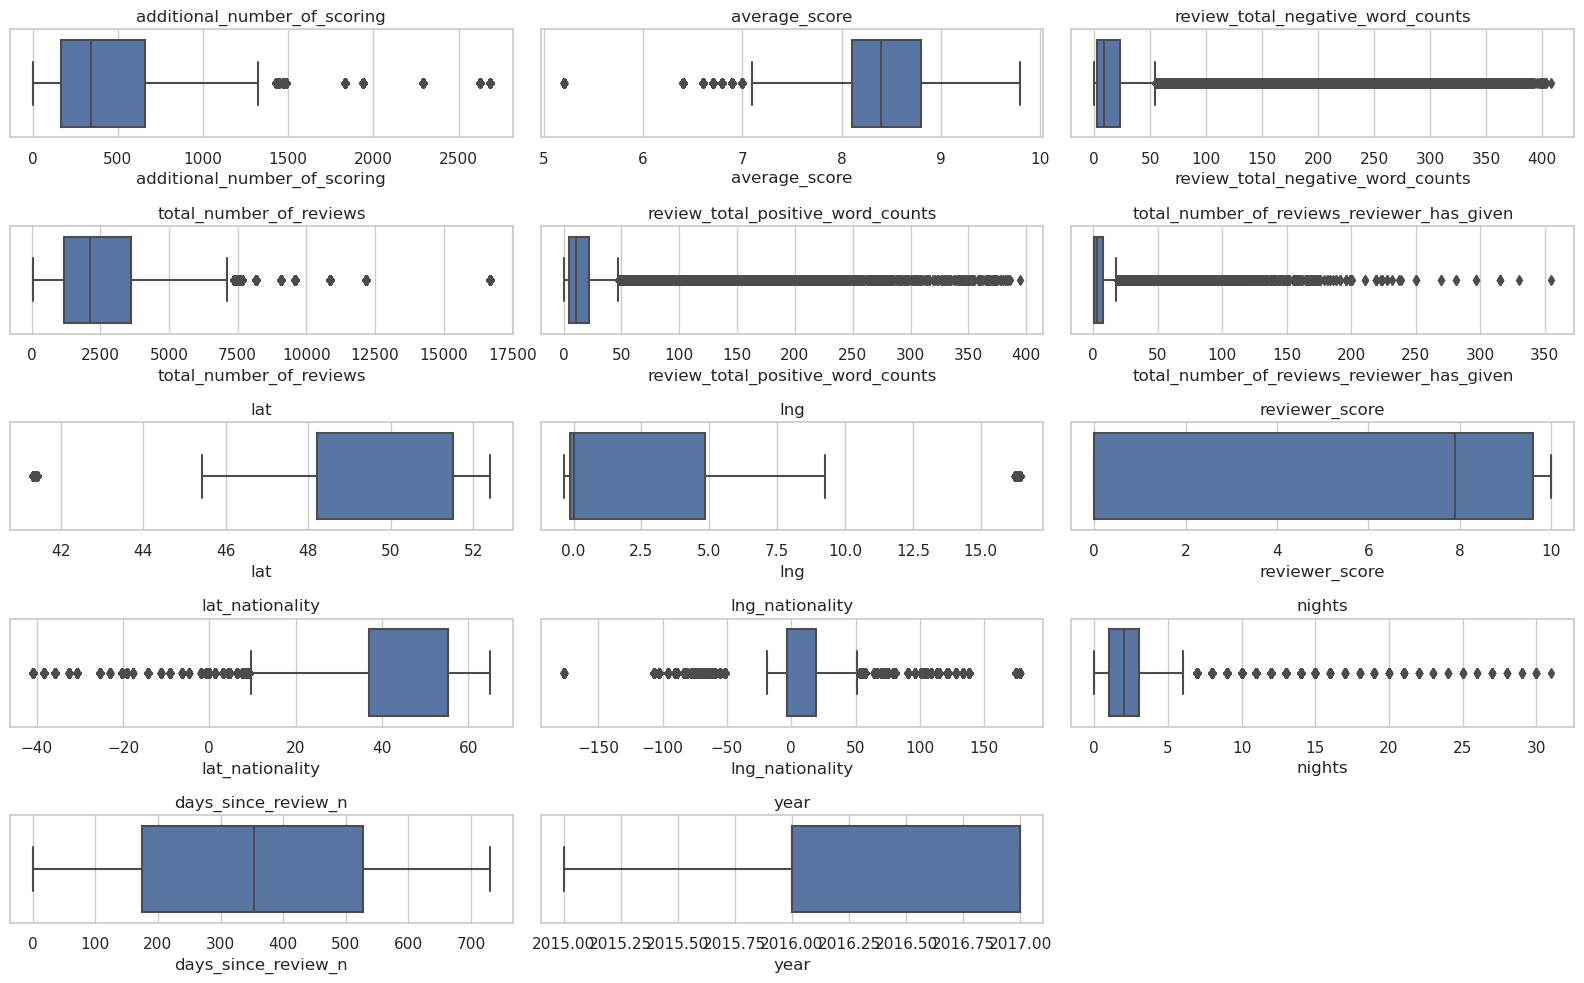

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

#num_cols = n_hotels.select_dtypes(include=['int64', 'float64']).columns.tolist()

plt.figure(figsize=(16, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols)//3 + 1, 3, i)
    sns.boxplot(x=n_hotels[col])
    plt.title(col)
plt.tight_layout()
plt.show()


## Outliers

**Tree-based models** split by thresholds, so extreme values won’t “pull” the model the way they would in regression.

In [37]:
#   3-sigma method (Tukey's method) to identify outliers in numerical features
import pandas as pd

def outliers_iqr(data, feature, k=3.0):
    """Detect and remove outliers using the Tukey IQR method."""
    x = data[feature]
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

# Create a cleaned copy of the dataset
data_cleaner = n_hotels.copy()

# Loop through numeric columns
for feature in num_cols:
    outliers, cleaned = outliers_iqr(data_cleaner, feature, k=3)
    print(f"{feature}: removed {len(outliers)} outliers")
    data_cleaner = cleaned  # progressively clean the dataset

additional_number_of_scoring: removed 13214 outliers
average_score: removed 65 outliers
review_total_negative_word_counts: removed 15574 outliers
total_number_of_reviews: removed 2823 outliers
review_total_positive_word_counts: removed 11558 outliers
total_number_of_reviews_reviewer_has_given: removed 18967 outliers
lat: removed 0 outliers
lng: removed 0 outliers
reviewer_score: removed 0 outliers
lat_nationality: removed 26593 outliers
lng_nationality: removed 78516 outliers
nights: removed 1266 outliers
days_since_review_n: removed 0 outliers
year: removed 0 outliers


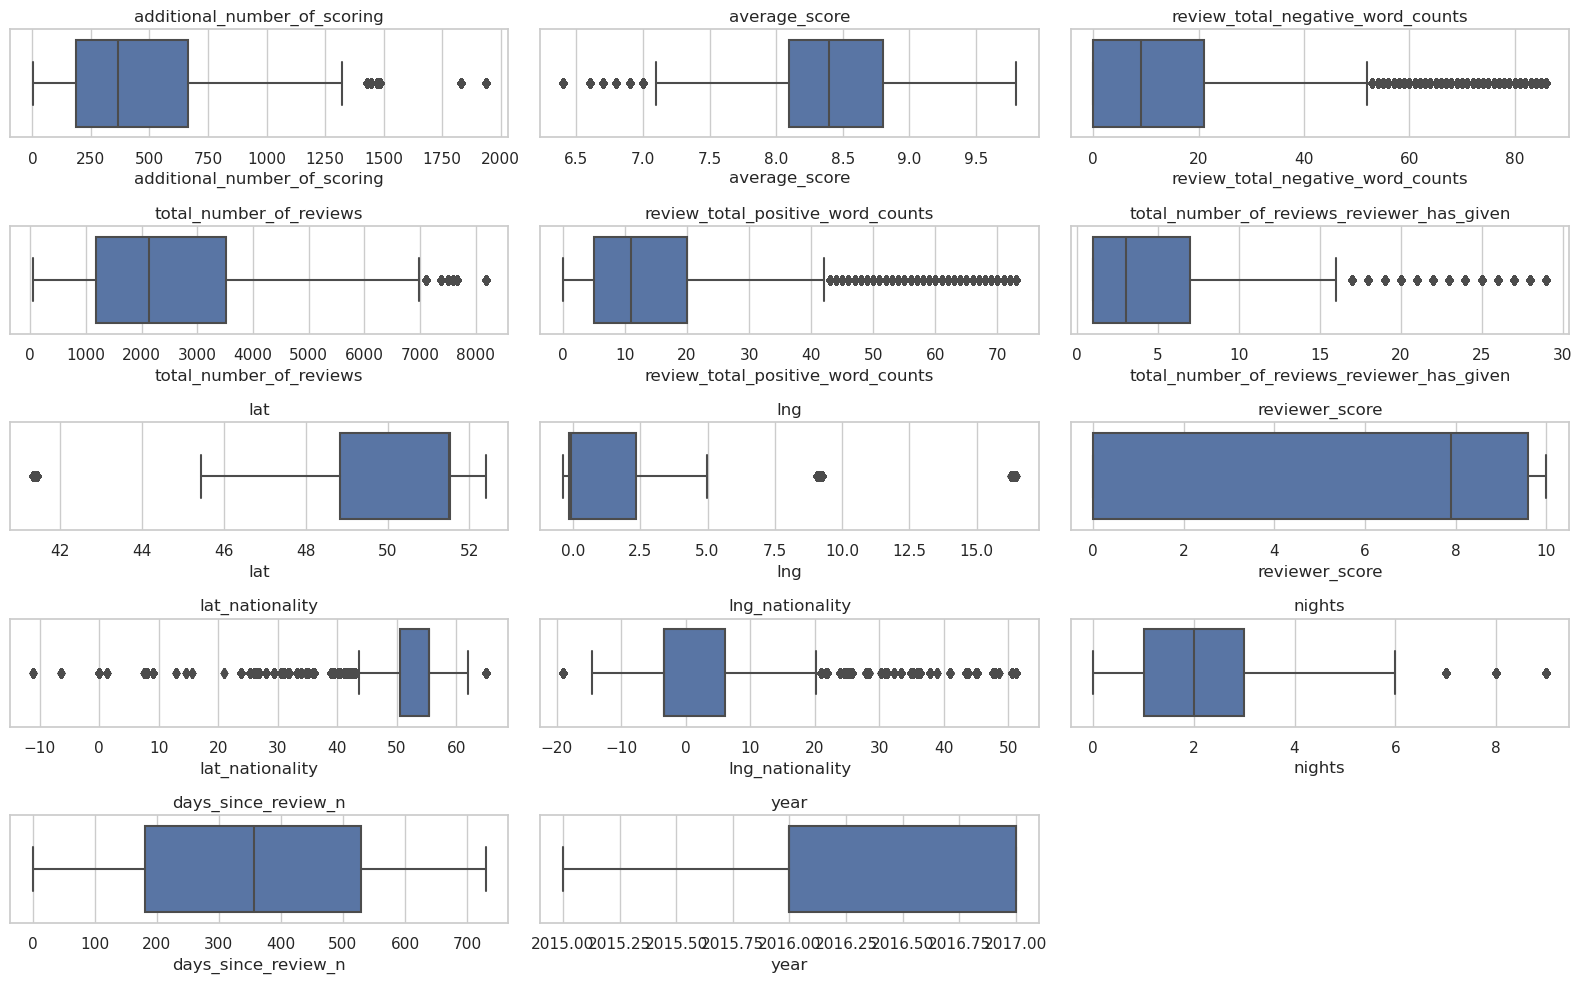

In [38]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols)//3 + 1, 3, i)
    sns.boxplot(x=data_cleaner[col])
    plt.title(col)
plt.tight_layout()
plt.show()

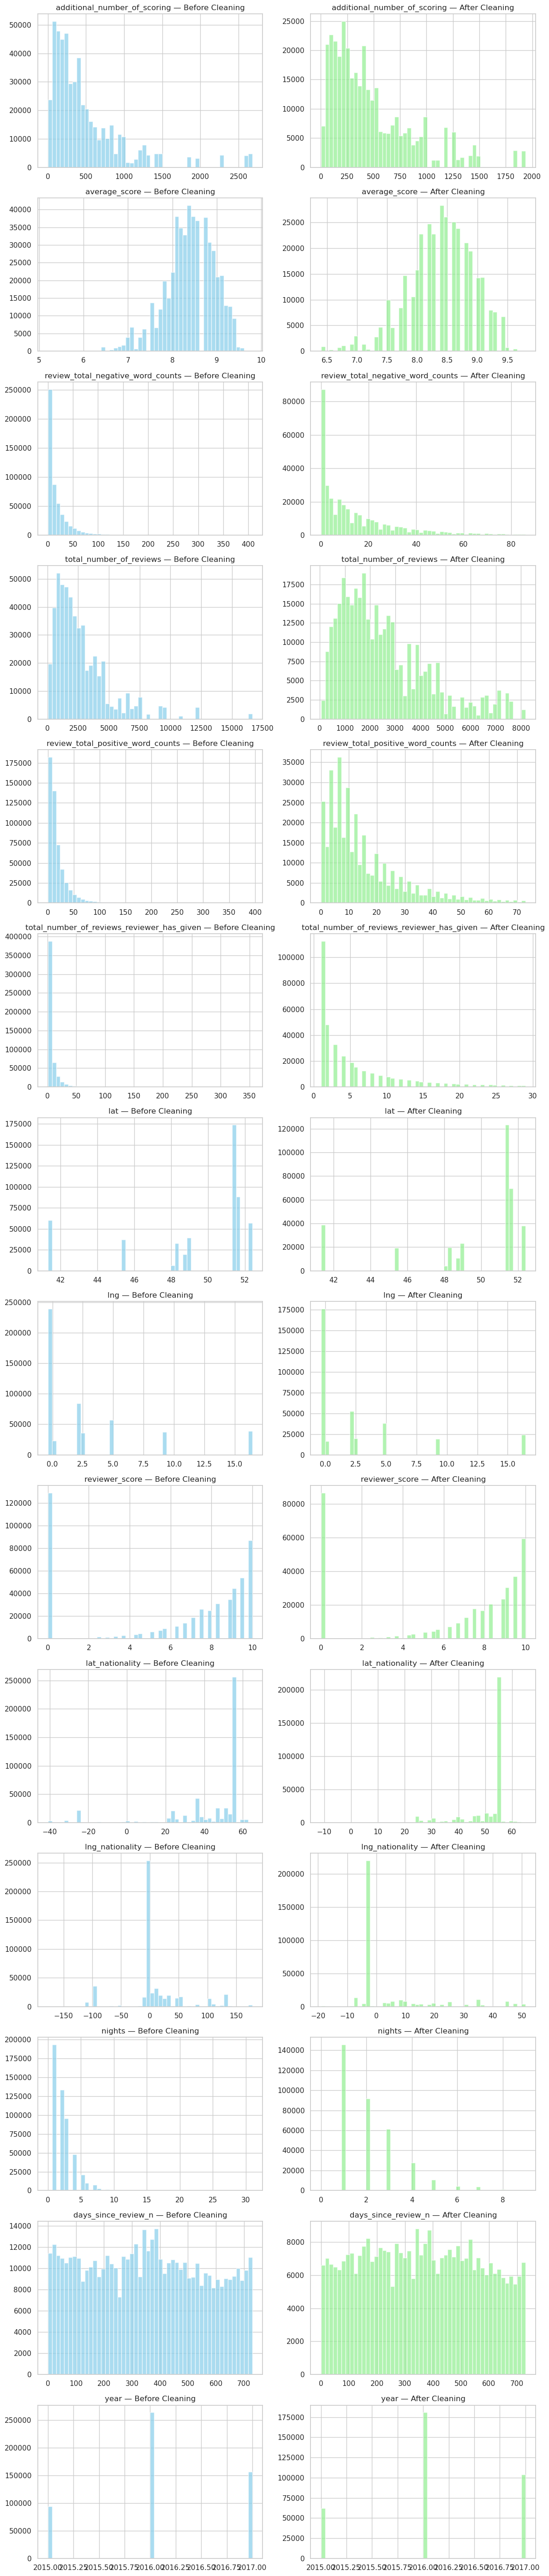

In [39]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 4 * len(num_cols)))

for i, col in enumerate(num_cols):
    # Before cleaning
    axes[i, 0].hist(n_hotels[col], bins=50, color='skyblue', alpha=0.7)
    axes[i, 0].set_title(f'{col} — Before Cleaning')

    # After cleaning
    axes[i, 1].hist(data_cleaner[col], bins=50, color='lightgreen', alpha=0.7)
    axes[i, 1].set_title(f'{col} — After Cleaning')

plt.tight_layout()
plt.show()

In [40]:
# Create a cleaned copy of the dataset
n_hotels_cleaner = n_hotels.copy()

# It seems like, some of the features do require outlier cleaning
# --- Apply cleaning only to selected columns ---
out_cols = [
    'total_number_of_reviews',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'nights'
]

for feature in out_cols:
    outliers, cleaned = outliers_iqr(n_hotels, feature, k=3)
    print(f"{feature}: removed {len(outliers)} outliers")
    n_hotels_cleaner = cleaned  # progressively remove outliers

total_number_of_reviews: removed 6045 outliers
review_total_negative_word_counts: removed 16084 outliers
review_total_positive_word_counts: removed 13156 outliers
total_number_of_reviews_reviewer_has_given: removed 20650 outliers
nights: removed 2509 outliers


## Scaling

For numeric features that vary a lot in magnitude and will otherwise dominate distance-based or linear models.

**Tree-based models** (RandomForest, XGBoost, etc.) are scale-invariant, so scaling is not needed.
However, if you’ll use regression, PCA, or neural networks, scaling is highly recommended.


In [41]:
'''
to_scale = [
    'additional_number_of_scoring',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews',
    'total_number_of_reviews_reviewer_has_given',
    'nights',
    'days_since_review_n'
]
no_scale = [
    'average_score',
    'reviewer_score',
    'lat', 'lng',
    'lat_nationality', 'lng_nationality',
    'year'
]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
n_hotels[to_scale] = scaler.fit_transform(n_hotels[to_scale])
'''

"\nto_scale = [\n    'additional_number_of_scoring',\n    'review_total_negative_word_counts',\n    'review_total_positive_word_counts',\n    'total_number_of_reviews',\n    'total_number_of_reviews_reviewer_has_given',\n    'nights',\n    'days_since_review_n'\n]\nno_scale = [\n    'average_score',\n    'reviewer_score',\n    'lat', 'lng',\n    'lat_nationality', 'lng_nationality',\n    'year'\n]\n\nfrom sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nn_hotels[to_scale] = scaler.fit_transform(n_hotels[to_scale])\n"

In [42]:
'''

import numpy as np

def cap_outliers(df, columns, factor=1.5):
    df = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        # cap values
        df[col] = np.where(df[col] < lower, lower,
                           np.where(df[col] > upper, upper, df[col]))
    return df

n_hotels[num_cols] = cap_outliers(n_hotels, num_cols)

'''

'\n\nimport numpy as np\n\ndef cap_outliers(df, columns, factor=1.5):\n    df = df.copy()\n    for col in columns:\n        Q1 = df[col].quantile(0.25)\n        Q3 = df[col].quantile(0.75)\n        IQR = Q3 - Q1\n        lower = Q1 - factor * IQR\n        upper = Q3 + factor * IQR\n        # cap values\n        df[col] = np.where(df[col] < lower, lower,\n                           np.where(df[col] > upper, upper, df[col]))\n    return df\n\nn_hotels[num_cols] = cap_outliers(n_hotels, num_cols)\n\n'

## Create interaction features

In [ ]:
# Weighted average influence

n_hotels['avg_score_times_total_reviews'] = n_hotels['average_score'] * n_hotels['total_number_of_reviews']
n_hotels['avg_score_times_additional_scoring'] = n_hotels['average_score'] * n_hotels['additional_number_of_scoring']

# ratio
n_hotels['positive_to_negative_ratio'] = (n_hotels['review_total_positive_word_counts'] + 1) / \
                                        (n_hotels['review_total_negative_word_counts'] + 1)


## Correlation map

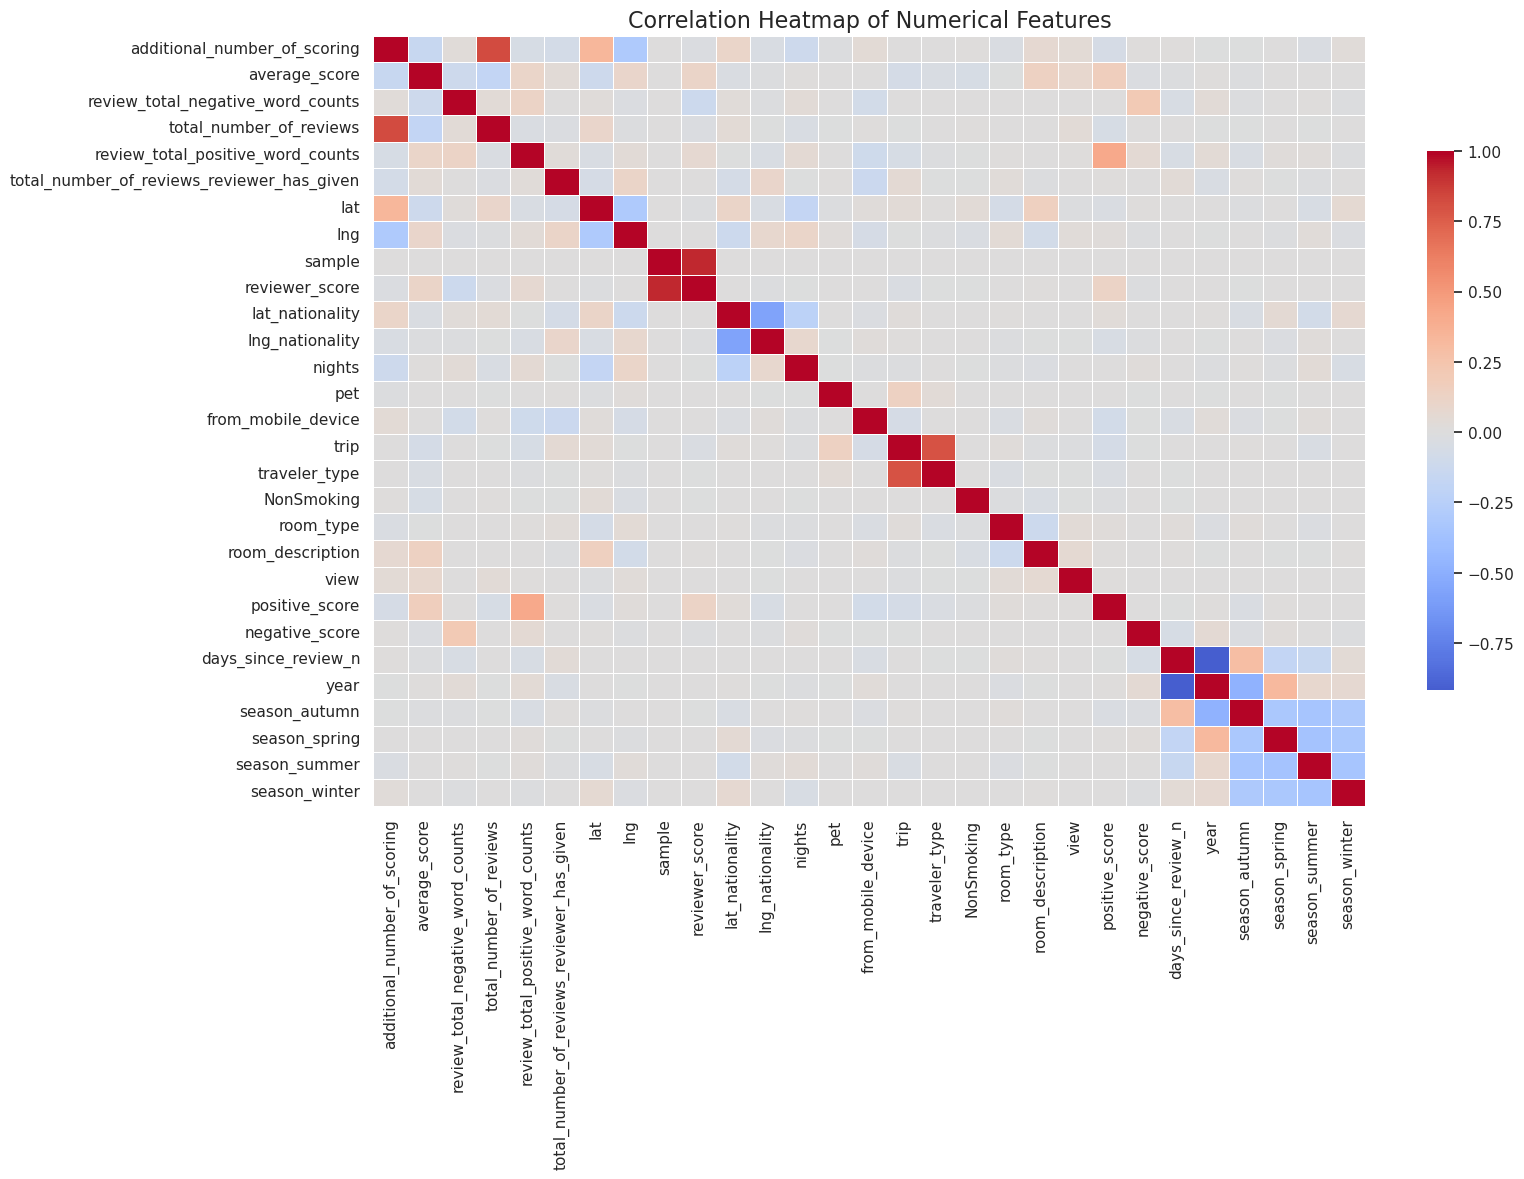

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation only for numerical columns
corr = n_hotels.select_dtypes(include=['number']).corr()

# Create a better visual
plt.figure(figsize=(16,10))
sns.heatmap(
    corr, 
    cmap='coolwarm',       # better contrast
    center=0,              # zero-centered colors
    annot=False,           # can set True for small matrices
    linewidths=0.5,
    cbar_kws={'shrink': .7}
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.show()

reviewer_score                                1.000000
sample                                        0.931811
positive_score                                0.119345
average_score                                 0.113628
review_total_positive_word_counts             0.069014
room_description                              0.014229
view                                          0.009914
lng                                           0.009870
season_winter                                 0.007706
from_mobile_device                            0.005084
lat_nationality                               0.004848
year                                          0.003456
season_spring                                 0.003268
total_number_of_reviews_reviewer_has_given    0.002410
room_type                                     0.000789
days_since_review_n                           0.000235
season_summer                                -0.001004
pet                                          -0.001043
NonSmoking

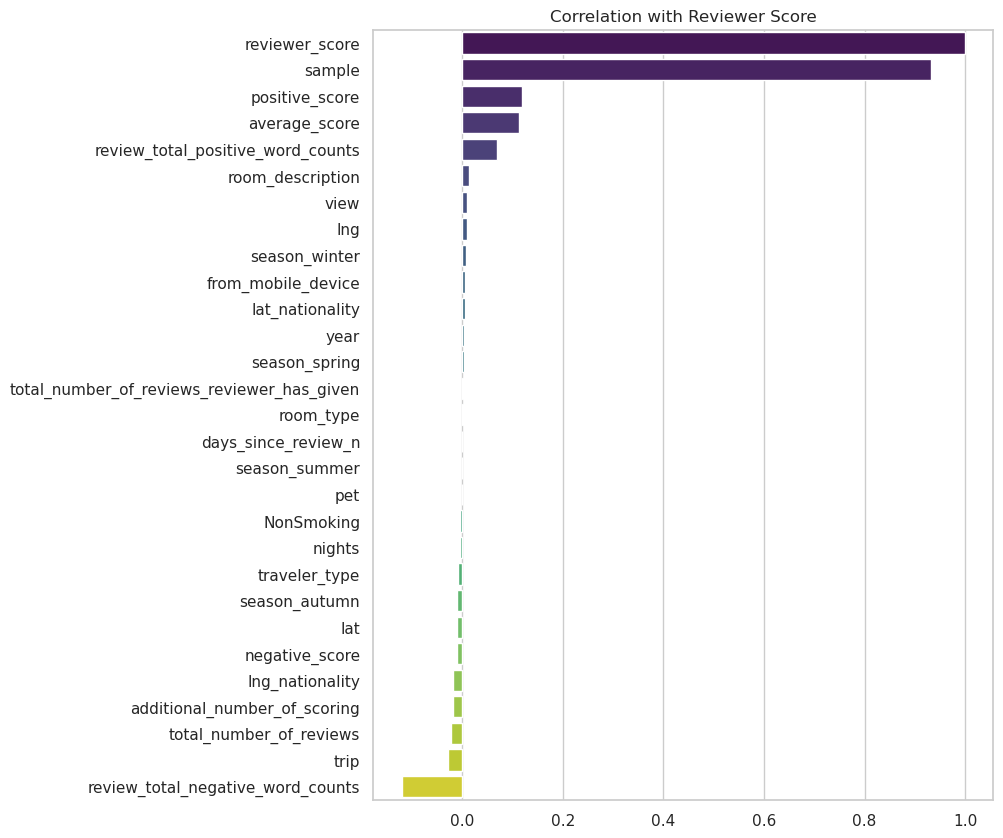

In [44]:
target_corr = corr['reviewer_score'].sort_values(ascending=False)
print(target_corr)

plt.figure(figsize=(8,10))
sns.barplot(y=target_corr.index, x=target_corr.values, palette='viridis')
plt.title("Correlation with Reviewer Score")
plt.show()

In [45]:
'''
#Scatter plots for relationships

plt.figure(figsize=(12,6))
sns.scatterplot(x='nights', y='reviewer_score', data=n_hotels, alpha=0.3)
plt.title('Reviewer Score vs Nights Stayed')
plt.show()
'''

"\n#Scatter plots for relationships\n\nplt.figure(figsize=(12,6))\nsns.scatterplot(x='nights', y='reviewer_score', data=n_hotels, alpha=0.3)\nplt.title('Reviewer Score vs Nights Stayed')\nplt.show()\n"

# Train/Test Split and Model Training

In [46]:
data_chosen = n_hotels.copy()
#data_chosen = n_hotels_cleaner.copy()

In [47]:
# =====================================================
# 10. Train/Test Split, Encoding, and Model Training
# =====================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import pandas as pd

# Separate train and test data
train_data = data_chosen.query('sample == 1').drop(['sample'], axis=1)
test_data = data_chosen.query('sample == 0').drop(['sample'], axis=1)

# Target and features
y = train_data['reviewer_score']
X = train_data.drop(['reviewer_score'], axis=1)

In [48]:
'''
# ==========================
# Encode categorical columns using One-Hot Encoding
# ==========================
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Apply the same encoding to the test set
X_test_raw = test_data.drop(['reviewer_score'], axis=1)
X_test_encoded = pd.get_dummies(X_test_raw, columns=categorical_cols, drop_first=True)

# Ensure train and test have the same columns (fill missing columns with 0)
X_test_encoded = X_test_encoded.reindex(columns=X_encoded.columns, fill_value=0)
'''

"\n# ==========================\n# Encode categorical columns using One-Hot Encoding\n# ==========================\nX_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)\n\n# Apply the same encoding to the test set\nX_test_raw = test_data.drop(['reviewer_score'], axis=1)\nX_test_encoded = pd.get_dummies(X_test_raw, columns=categorical_cols, drop_first=True)\n\n# Ensure train and test have the same columns (fill missing columns with 0)\nX_test_encoded = X_test_encoded.reindex(columns=X_encoded.columns, fill_value=0)\n"

In [55]:
# ==========================
# Split train data into train/test sets
# ==========================
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==========================
# Optional: Scale numeric features (not required for Random Forest)
# ==========================
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_valid_scaled = scaler.transform(X_valid)



MAE: 0.87
RMSE: 1.16
R²: 0.491
Test MAPE: 12.49%


#  Hyperparameter tuning

In [ ]:
# ==========================
# Train Random Forest Model
# ==========================
#rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
#rf.fit(X_train, y_train)

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(rf, param_distributions=param_grid,
                            n_iter=20, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
search.fit(X_train, y_train)

best_rf = search.best_estimator_

In [ ]:
# ==========================
# Evaluate model
# ==========================
y_pred = best_rf.predict(X_valid)
mape = metrics.mean_absolute_percentage_error(y_valid, y_pred) * 100
mae = metrics.mean_absolute_error(y_valid, y_pred)
rmse = metrics.mean_squared_error(y_valid, y_pred, squared=False)
r2 = metrics.r2_score(y_valid, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")
print(f"Test MAPE: {mape:.2f}%")

# Visual inspection

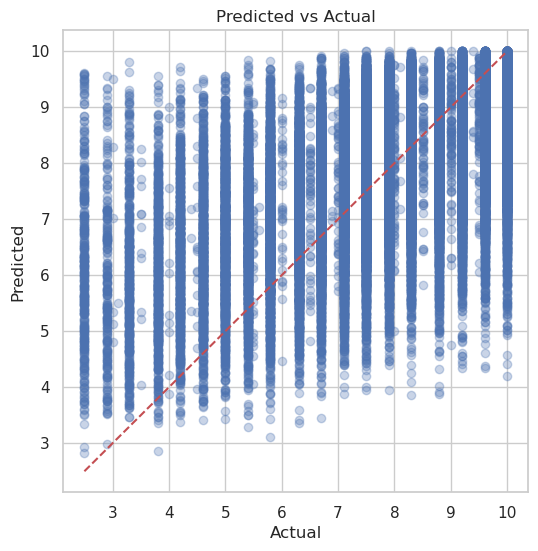

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_valid, y_pred, alpha=0.3)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

## (Optional) Feature Importance Plot

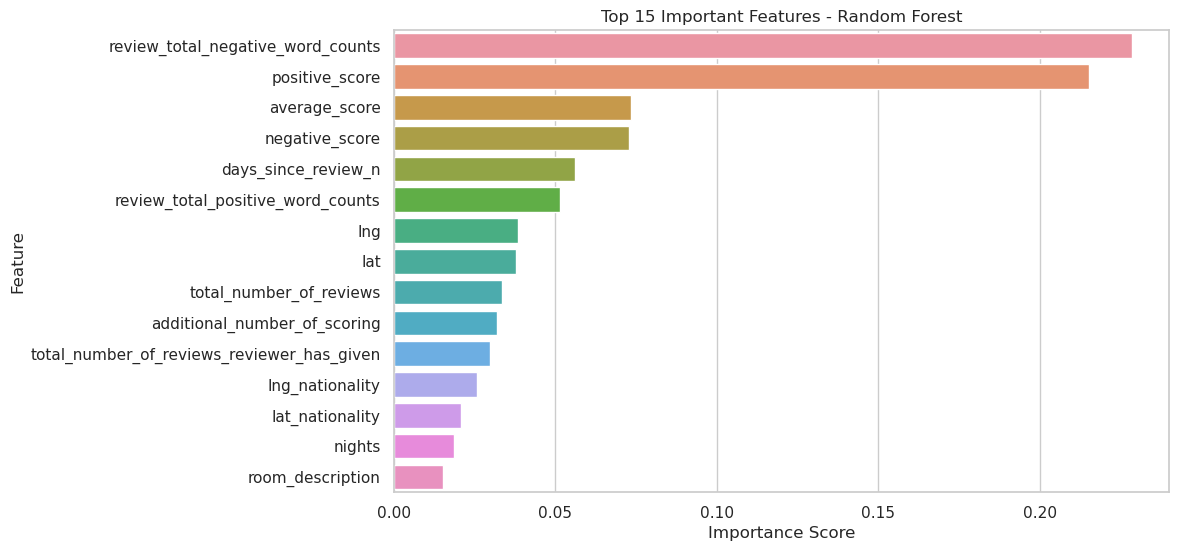

In [52]:
# =====================================================
# 12. Feature Importance Visualization
# =====================================================
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(15), y=importances.head(15).index)
plt.title('Top 15 Important Features - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()